# Settings

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font_path = '/home/b2018yniki/local/lib/font/TakaoPGothic.ttf'  #DLしたパスを指定. /font以下でなくても良い
font_prop = FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()
import seaborn as sns

import optuna

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

def confusion2score(confusion):
    tp, fn, fp, tn = confusion.ravel()
    if tp == None:
        tp = 0
    if fn == None:
        fn = 0
    if fp == None:
        fp = 0
    if tn == None:
        tn = 0
    acc = (tp + tn) / (tp + fn + fp + tn)
    if (tp+fp) == 0:
        pre=0
    else:
        pre = tp / (tp + fp)
    if (tp+fn) == 0:
        rec=0
    else:
        rec = tp / (tp + fn)
    if (2*tp+fp+fn) == 0:
        f1=0
    else:
        f1  = (2 * tp) / (2*tp + fp + fn)
    return (acc, pre, rec, f1)

import MeCab
# dict_path = '-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd'    # path of sparrow
dict_path = '-d /home/b2018yniki/local/lib/mecab/dic/mecab-ipadic-neologd/'    # path of hpc

def get_tango(sen):
    word_list = []
    tagger = MeCab.Tagger(dict_path)
    for word_line in tagger.parse(sen).split("\n"):
        if word_line.strip() == "EOS":
            break
        (word, temp) = word_line.split("\t")
        temps = temp.split(',')
        if "記号" == temps[0]:
            continue
        if "数" == temps[1]:
            continue
        word_list.append(word)
    return u" ".join(word_list)

# Logistic Regression

In [5]:
train_df = pd.read_csv('/home/b2018yniki/data/nikkei/train.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
test_df  = pd.read_csv('/home/b2018yniki/data/nikkei/test.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
total_df = pd.concat([train_df, test_df], ignore_index=True).drop_duplicates()

X = total_df.body
y = total_df.target.apply(lambda x: 0 if x==1 else 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2019)
del train_df, test_df, total_df, X, y

X_train = [get_tango(text) for text in X_train.values]
X_test  = [get_tango(text) for text in X_test.values]

vect = CountVectorizer(min_df=10, ngram_range=(1,3))
vect.fit(X_train)
X_train = vect.transform(X_train)
X_test  = vect.transform(X_test)

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
X_train = pd.DataFrame(X_train.toarray(), columns=feature_names)
X_test  = pd.DataFrame(X_test.toarray(), columns=feature_names)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

lgreg = LogisticRegression(penalty='l2', C=1.0, random_state=2019)
lgreg.fit(X_train, y_train)
y_pred = lgreg.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
scores    = confusion2score(confusion)
auc       = roc_auc_score(y_test, y_pred)
print('Confusion Matrix: ')
print(confusion)
print('scores: ', scores)
print('AUC: ', auc)

Number of features: 463
X_train shape:  (1500, 463)
X_test shape:  (501, 463)


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion Matrix: 
[[172  42]
 [ 34 253]]
scores:  (0.8483033932135728, 0.8349514563106796, 0.8037383177570093, 0.819047619047619)
AUC:  0.8426357094011528


### without feature engineering

In [3]:
def create_model_pred(X, y, n_gram, min_df, penalty, C):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2019)
    X_train = [get_tango(text) for text in X_train.values]
    X_test  = [get_tango(text) for text in X_test.values]
    
    vect = CountVectorizer(min_df=min_df, ngram_range=(1,n_gram))
    vect.fit(X_train)
    X_train = vect.transform(X_train)
    X_test  = vect.transform(X_test)

    lgreg = LogisticRegression(penalty=penalty, C=C, random_state=2019)
    lgreg.fit(X_train, y_train)
    y_pred = lgreg.predict(X_test)
    
    confusion = confusion_matrix(y_test, y_pred)
    scores    = confusion2score(confusion)
    return scores

train_df = pd.read_csv('/home/b2018yniki/data/nikkei/train.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
test_df  = pd.read_csv('/home/b2018yniki/data/nikkei/test.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
total_df = pd.concat([train_df, test_df], ignore_index=True).drop_duplicates()

X = total_df.body
y = total_df.target.apply(lambda x: 0 if x==1 else 1)

del train_df, test_df, total_df

create_model_pred(X, y, n_gram=3, min_df=10, penalty='l2', C=1.0)

/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.8483033932135728, 0.8349514563106796, 0.8037383177570093, 0.819047619047619)

### with feature engineering

In [6]:
train_df = pd.read_csv('/home/b2018yniki/data/nikkei/train.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
test_df  = pd.read_csv('/home/b2018yniki/data/nikkei/test.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
total_df = pd.concat([train_df, test_df], ignore_index=True).drop_duplicates()

X = total_df.body
y = total_df.target.apply(lambda x: 0 if x==1 else 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2019)
del train_df, test_df, total_df, X, y

X_train = [get_tango(text) for text in X_train.values]
X_test  = [get_tango(text) for text in X_test.values]

vect = CountVectorizer(min_df=10, ngram_range=(1,3))
vect.fit(X_train)
X_train = vect.transform(X_train)
X_test  = vect.transform(X_test)

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
X_train = pd.DataFrame(X_train.toarray(), columns=feature_names)
X_test  = pd.DataFrame(X_test.toarray(), columns=feature_names)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=2019)
rf_model.fit(X_train, y_train)

fi_df = pd.DataFrame(rf_model.feature_importances_, index=feature_names)
use_cols = fi_df[fi_df[0] > 0.0].index.values

print('# of use columns: ', len(use_cols))
X_train = X_train[use_cols]
X_test  = X_test[use_cols]

lgreg = LogisticRegression(penalty='l2', C=1.0, random_state=2019)
lgreg.fit(X_train, y_train)
y_pred = lgreg.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
scores    = confusion2score(confusion)
auc       = roc_auc_score(y_test, y_pred)
print('Confusion Matrix: ')
print(confusion)
print('scores: ', scores)
print('AUC: ', auc)

Number of features: 463
X_train shape:  (1500, 463)
X_test shape:  (501, 463)
# of use columns:  438


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion Matrix: 
[[174  40]
 [ 35 252]]
scores:  (0.8502994011976048, 0.8325358851674641, 0.8130841121495327, 0.8226950354609929)
AUC:  0.8455664463186687


In [2]:
def create_model_pred2(X, y, n_gram, min_df, penalty, C, feat_eng=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2019)
    X_train = [get_tango(text) for text in X_train.values]
    X_test  = [get_tango(text) for text in X_test.values]
    
    vect = CountVectorizer(min_df=min_df, ngram_range=(1,n_gram))
    vect.fit(X_train)
    X_train = vect.transform(X_train)
    X_test  = vect.transform(X_test)
    if feat_eng:
        rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=2019)
        rf_model.fit(X_train, y_train)
        feature_names = vect.get_feature_names()
        X_train = pd.DataFrame(X_train.toarray(), columns=feature_names)
        X_test  = pd.DataFrame(X_test.toarray(), columns=feature_names)
        fi_df = pd.DataFrame(rf_model.feature_importances_, index=feature_names)
        use_cols = fi_df[fi_df[0] > 0.0].index.values
        X_train = X_train[use_cols]
        X_test  = X_test[use_cols]
    lgreg = LogisticRegression(penalty=penalty, C=C, random_state=2019)
    lgreg.fit(X_train, y_train)
    y_pred = lgreg.predict(X_test)
    
    confusion = confusion_matrix(y_test, y_pred)
    scores    = confusion2score(confusion)
    return scores

train_df = pd.read_csv('/home/b2018yniki/data/nikkei/train.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
test_df  = pd.read_csv('/home/b2018yniki/data/nikkei/test.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
total_df = pd.concat([train_df, test_df], ignore_index=True).drop_duplicates()

X = total_df.body
y = total_df.target.apply(lambda x: 0 if x==1 else 1)

del train_df, test_df, total_df

create_model_pred(X, y, n_gram=3, min_df=10, penalty='l2', C=1.0, feat_eng=True)

/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.8502994011976048,
 0.8325358851674641,
 0.8130841121495327,
 0.8226950354609929)

# Hyperparameter Search by Optuna

### without feature enginnering

In [5]:
train_df = pd.read_csv('/home/b2018yniki/data/nikkei/train.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
test_df  = pd.read_csv('/home/b2018yniki/data/nikkei/test.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
total_df = pd.concat([train_df, test_df], ignore_index=True).drop_duplicates()

X = total_df.body
y = total_df.target.apply(lambda x: 0 if x==1 else 1)

def objective(trial):
    n_gram  = trial.suggest_int('n_gram', 1, 5)
    min_df  = int(trial.suggest_discrete_uniform('min_df', 5, 20, 5))
    C       = trial.suggest_loguniform('C', 1e-2, 100)
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1'])
    
    scores = create_model_pred(X, y, n_gram, min_df, penalty, C)
    
    return 1 - scores[3]

study = optuna.create_study()
study.optimize(objective, n_trials=100)

/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[I 2019-08-04 11:02:47,311] Finished trial#0 resulted in value: 0.22596153846153844. Current best value is 0.22596153846153844 with parameters: {'n_gram': 3, 'min_df': 20.0, 'C': 14.540547329880708, 'penalty': 'l1'}.
/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[I 2019-08-04 11:02:49,274] Finished trial#1 resulted in value: 0.41874999999999996. Current best value is 0.22596153846153844 with parameters: {'n_gram': 3, 'min_df': 20.0, 'C': 14.540547329880708, 'penalty': 'l1'}.
/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: F

In [6]:
print('best parameters: ', study.best_params)
print('best f1 score: {}'.format(1-study.best_value))

best parameters:  {'n_gram': 2, 'min_df': 5.0, 'C': 1.3584342266504392, 'penalty': 'l2'}
best f1 score: 0.8341232227488151


#### scores of the best parameter

In [7]:
train_df = pd.read_csv('/home/b2018yniki/data/nikkei/train.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
test_df  = pd.read_csv('/home/b2018yniki/data/nikkei/test.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
total_df = pd.concat([train_df, test_df], ignore_index=True).drop_duplicates()

X = total_df.body
y = total_df.target.apply(lambda x: 0 if x==1 else 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2019)
del train_df, test_df, total_df, X, y

X_train = [get_tango(text) for text in X_train.values]
X_test  = [get_tango(text) for text in X_test.values]

vect = CountVectorizer(min_df=5, ngram_range=(1,2))
vect.fit(X_train)
X_train = vect.transform(X_train)
X_test  = vect.transform(X_test)

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
X_train = pd.DataFrame(X_train.toarray(), columns=feature_names)
X_test  = pd.DataFrame(X_test.toarray(), columns=feature_names)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

lgreg = LogisticRegression(penalty='l2', C=1.0, random_state=2019)
lgreg.fit(X_train, y_train)
y_pred = lgreg.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
scores    = confusion2score(confusion)
auc       = roc_auc_score(y_test, y_pred)
print('Confusion Matrix: ')
print(confusion)
print('scores: ', scores)
print('AUC: ', auc)

Number of features: 1141
X_train shape:  (1500, 1141)
X_test shape:  (501, 1141)


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion Matrix: 
[[174  40]
 [ 30 257]]
scores:  (0.8602794411177644, 0.8529411764705882, 0.8130841121495327, 0.8325358851674641)
AUC:  0.854277247712397


### with feature engineering

In [3]:
train_df = pd.read_csv('/home/b2018yniki/data/nikkei/train.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
test_df  = pd.read_csv('/home/b2018yniki/data/nikkei/test.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
total_df = pd.concat([train_df, test_df], ignore_index=True).drop_duplicates()

X = total_df.body
y = total_df.target.apply(lambda x: 0 if x==1 else 1)

def objective(trial):
    n_gram  = trial.suggest_int('n_gram', 1, 5)
    min_df  = int(trial.suggest_discrete_uniform('min_df', 5, 20, 5))
    C       = trial.suggest_loguniform('C', 1e-2, 100)
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1'])
    feat_eng= trial.suggest_categorical('feat_eng', [True, False])
    
    scores = create_model_pred2(X, y, n_gram, min_df, penalty, C, feat_eng)
    
    return 1 - scores[3]

study = optuna.create_study()
study.optimize(objective, n_trials=100)

print('best parameters: ', study.best_params)
print('best f1 score: {}'.format(1-study.best_value))

/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[I 2019-07-30 22:02:05,516] Finished trial#0 resulted in value: 0.18501170960187352. Current best value is 0.18501170960187352 with parameters: {'n_gram': 2, 'min_df': 5.0, 'C': 6.1906286948397575, 'penalty': 'l2', 'feat_eng': True}.
/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[I 2019-07-30 22:02:07,733] Finished trial#1 resulted in value: 0.19437939110070257. Current best value is 0.18501170960187352 with parameters: {'n_gram': 2, 'min_df': 5.0, 'C': 6.1906286948397575, 'penalty': 'l2', 'feat_eng': True}.
/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklea

best parameters:  {'n_gram': 4, 'min_df': 5.0, 'C': 1.0478819712204026, 'penalty': 'l2', 'feat_eng': True}
best f1 score: 0.8361858190709046


### scores of best parameters

In [6]:
train_df = pd.read_csv('/home/b2018yniki/data/nikkei/train.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
test_df  = pd.read_csv('/home/b2018yniki/data/nikkei/test.txt', sep='\t', header=None, names=['target', 'time', 'body']).drop('time', axis=1)
total_df = pd.concat([train_df, test_df], ignore_index=True).drop_duplicates()

X = total_df.body
y = total_df.target.apply(lambda x: 0 if x==1 else 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2019)
del train_df, test_df, total_df, X, y

X_train = [get_tango(text) for text in X_train.values]
X_test  = [get_tango(text) for text in X_test.values]

vect = CountVectorizer(min_df=5, ngram_range=(1,4))
vect.fit(X_train)
X_train = vect.transform(X_train)
X_test  = vect.transform(X_test)

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
X_train = pd.DataFrame(X_train.toarray(), columns=feature_names)
X_test  = pd.DataFrame(X_test.toarray(), columns=feature_names)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=2019)
rf_model.fit(X_train, y_train)
fi_df = pd.DataFrame(rf_model.feature_importances_, index=feature_names)
use_cols = fi_df[fi_df[0] > 0.0].index.values
print('# of use columns: ', len(use_cols))
X_train = X_train[use_cols]
X_test  = X_test[use_cols]

lgreg = LogisticRegression(penalty='l2', C=1.0478819712204026, random_state=2019)
lgreg.fit(X_train, y_train)
y_pred = lgreg.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)
scores    = confusion2score(confusion)
auc       = roc_auc_score(y_test, y_pred)
print('Confusion Matrix: ')
print(confusion)
print('scores: ', scores)
print('AUC: ', auc)

Number of features: 1186
X_train shape:  (1500, 1186)
X_test shape:  (501, 1186)
# of use columns:  849


/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion Matrix: 
[[171  43]
 [ 24 263]]
scores:  (0.8662674650698603, 0.8769230769230769, 0.7990654205607477, 0.8361858190709046)
AUC:  0.8577208635904784


In [7]:
fi_df = pd.DataFrame(rf_model.feature_importances_, index=feature_names).sort_values(0, ascending=False)
fi_df.head(10)

,0
ため,0.133626
この ため,0.085623
記者会見,0.085469
この,0.058276
事件,0.038965
影響,0.036063
について,0.027376
ある,0.024695
容疑者,0.023329
示し,0.020973


findfont: Font family ['TakaoPGothic'] not found. Falling back to DejaVu Sans.
/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12383 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12417 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12371 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Gl

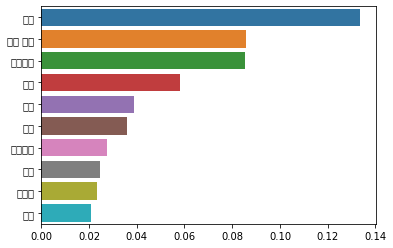

In [4]:
plt.figure()
sns.barplot(x=fi_df.head(10)[0].values,y=fi_df.head(10).index.values, data=fi_df.head(10))
plt.show()

In [57]:
matplotlib.matplotlib_fname()

'/home/b2018yniki/.pyenv/versions/3.7.1/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'

In [58]:
print(matplotlib.get_configdir())
!ls /home/b2018yniki/.config/matplotlib

/home/b2018yniki/.config/matplotlib


In [5]:
print(matplotlib.get_cachedir())
!ls /home/b2018yniki/.cache/matplotlib
# !rm ~/.cache/matplotlib/fontlist-v310.json
# !ls /home/b2018yniki/.cache/matplotlib

/home/b2018yniki/.cache/matplotlib
fontlist-v310.json  tex.cache
